# Lab 3: Building a Travel Planner with a Simple LangGraph

## Overview

This lab guides you through the process of creating a simple Travel Planner using LangGraph, a library for building stateful, multi-step applications with language models. The Travel Planner demonstrates how to structure a conversational AI application that collects user input and generates personalized travel itineraries.

## Intro to Agents
- Agents are leverage LLM to `think step by step` and then plan the execution
- Agents have access to tools
- Agents have access to memory. Below diagram illustrates this concept

#### Memory Management
Memory is key for any agentic conversation which is `Multi-Turn` or `Multi-Agent` colloboration conversation and more so if it spans multiple days. The 3 main aspects of Agents are:
1. Tools
2. Memory
3. Planners

- ![Agent memory](./images/agents_memory_light.png)

## Use Case Details

Our Travel Planner follows a straightforward, three-step process:

1. **Initial User Input**: 
   - The application prompts the user to enter their desired travel plan to get assistance from AI Agent.
   - This information is stored in the state.

2. **Interests Input**:
   - The user is asked to provide their interests for the trip.
   - These interests are stored as a list in the state.

3. **Itinerary Creation**:
   - Using the collected city and interests, the application leverages a language model to generate a personalized day trip itinerary.
   - The generated itinerary is presented to the user.

The flow between these steps is managed by LangGraph, which handles the state transitions and ensures that each step is executed in the correct order.

The below diagram illustrates this:

![Travel Planner Agent](./images/agents_itinerary.png)

### Setup and Imports

First, let's import the necessary modules and set up our environment.

In [1]:
from typing import TypedDict, Annotated, List
from langgraph.graph import StateGraph, END
from langchain_core.messages import HumanMessage, AIMessage
from langchain_core.runnables.graph import MermaidDrawMethod
from IPython.display import display, Image


## LangGraph -- State Graph, Nodes and Edges

First, we are initializing the ```StateGraph```. This object will encapsulate the graph being traversed during excecution.

Then we define the **nodes** in our graph. In LangGraph, nodes are typically python functions. There are two main nodes we will use for our graph:
- The agent node: responsible for deciding what (if any) actions to take.
- The tool node: This node will orchestrate calling the respective tool and returning the output. This means if the agent decides to take an action, this node will then execute that action.

**Edges** define how the logic is routed and how the graph decides to stop. This is a big part of how your agents work and how different nodes communicate with each other. There are a few key types of edges:

- Normal Edges: Go directly from one node to the next.
- Conditional Edges: Call a function to determine which node(s) to go to next.
- Entry Point: Which node to call first when user input arrives.
- Conditional Entry Point: Call a function to determine which node(s) to call first when user input arrives.

In our case we need to define a conditional edge that routes to the ```ToolNode``` when a tool get called in the agent node, i.e. when the LLM determines the requirement of tool use. With ```tools_condition```, LangGraph provides a preimplemented function handling this. Further, an edge from the ```START```node to the ```assistant```and from the ```ToolNode``` back to the ```assistant``` are required.

We are adding the nodes, edges as well as a persistant memory to the ```StateGraph``` before we compile it. 

### Define Agent State

We'll define the state that our agent will maintain throughout its operation. First, define the [State](https://langchain-ai.github.io/langgraph/concepts/low_level/#state) of the graph.  The State schema serves as the input schema for all Nodes and Edges in the graph.

Let's use the `TypedDict` class from python's `typing` module as our schema, which provides type hints for the keys.

### Key Components

1. **StateGraph**: The core of our application, defining the flow of our Travel Planner.
2. **PlannerState**: A custom type representing the state of our planning process.
3. **Node Functions**: Individual steps in our planning process (input_city, input_interests, create_itinerary).
4. **LLM Integration**: Utilizing a language model to generate the final itinerary.
5. **Memory Integration**: Utilizing long term and short term memory for conversations

#### Advanced concepts

Now we'll define the main functions nodes that our agent will use: get interests, create itinerary. 

- [Nodes](https://langchain-ai.github.io/langgraph/concepts/low_level/#nodes) are python functions.
- The first positional argument is the state, as defined above. 
- State is a `TypedDict` with schema as defined above, each node can access the key, `graph_state`, with `state['graph_state']`. 
- Each node returns a new value of the state key `graph_state`.
  
By default, the new value returned by each node [will override](https://langchain-ai.github.io/langgraph/concepts/low_level/#reducers) the prior state value.

### Memory

1. We will disscuss memory is detail in subsequent sections below how some some key points
2. We have `Conversational Memory` which is needed for all agents to have context since this is a `ChatBot` which needs history of conversations
3. We usually summarize these into a **Summary Conversation** alternating with Human | AI for multi session conversations
4. We have the concept of Graph State which is for Async workflows where we need to resume the workflow from a **certain point** in history

For `A-Sync` workflows where we need to persist the state of the graph and bring it back once we get the required data. below diagram explains this concept. 

![Graph state](./images/graph_state_light.png)


### Define Agent Nodes

we will create a simple graph with 
- user travel plans
- invoke with Bedrock
- generate the travel plan for the day 
- ability to add or modify the plan

In [2]:
class PlannerState(TypedDict):
    messages: Annotated[List[HumanMessage | AIMessage], "The messages in the conversation"]
    itinerary: str
    city: str
    user_message: str

### Set Up Language Model and Prompts


In [3]:

from langchain_aws import ChatBedrockConverse
import boto3
from langgraph.checkpoint.memory import MemorySaver
from langchain_core.runnables.config import RunnableConfig
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder

model_id = "us.amazon.nova-lite-v1:0"
bedrock_client = boto3.client("bedrock-runtime", region_name="us-east-1")

provider_id = "amazon"

llm = ChatBedrockConverse(
    model=model_id,
    provider=provider_id,
    temperature=0,
    max_tokens=None,
    client=bedrock_client,
)


itinerary_prompt = ChatPromptTemplate.from_messages([
    ("system", "You are a helpful travel assistant. Create a day trip itinerary for {city} based on the user's interests. Use the below chat conversation and the latest input from Human to get the user interests. Provide a brief, bulleted itinerary."),
    MessagesPlaceholder("chat_history"),
    ("human", "{user_message}"),
])

### Define the nodes and Edges

In [4]:
def input_interests(state: PlannerState) -> PlannerState:
    user_message = state['user_message']


    if not state.get('messages', None) : state['messages'] = []
    return {
        **state,
    }

def create_itinerary(state: PlannerState) -> PlannerState:
    response = llm.invoke(itinerary_prompt.format_messages(city=state['city'], user_message=state['user_message'], chat_history=state['messages']))
    print("\nFinal Itinerary:")
    print(response.content)
    return {
        **state,
        "messages": state['messages'] + [HumanMessage(content=state['user_message']),AIMessage(content=response.content)],
        "itinerary": response.content
    }

### Create and Compile the Graph

Now we'll create our LangGraph workflow and compile it. We build the graph from our [components](
https://langchain-ai.github.io/langgraph/concepts/low_level/) defined above. The [StateGraph class](https://langchain-ai.github.io/langgraph/concepts/low_level/#stategraph) is the graph class that we can use.
 
First, we initialize a StateGraph with the `State` class we defined above. Then, we add our nodes and edges. We use the [`START` Node, a special node](https://langchain-ai.github.io/langgraph/concepts/low_level/#start-node) that sends user input to the graph, to indicate where to start our graph. The [`END` Node](https://langchain-ai.github.io/langgraph/concepts/low_level/#end-node) is a special node that represents a terminal node. 


In [5]:
workflow = StateGraph(PlannerState)

#workflow.add_node("input_city", input_city)
workflow.add_node("input_interests", input_interests)
workflow.add_node("create_itinerary", create_itinerary)

workflow.set_entry_point("input_interests")

#workflow.add_edge("input_city", "input_interests")
workflow.add_edge("input_interests", "create_itinerary")
workflow.add_edge("create_itinerary", END)

# The checkpointer lets the graph persist its state
# this is a complete memory for the entire graph.
memory = MemorySaver()
app = workflow.compile(checkpointer=memory)

### Display the graph structure

Finally, we [compile our graph](https://langchain-ai.github.io/langgraph/concepts/low_level/#compiling-your-graph) to perform a few basic checks on the graph structure. We can visualize the graph as a [Mermaid diagram](https://github.com/mermaid-js/mermaid).

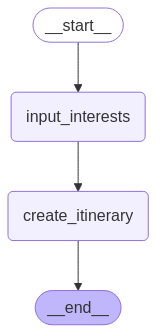

In [6]:
display(
    Image(
        app.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API,
        )
    )
)

### Define the function that runs the graph

When we compile the graph, we turn it into a LangChain Runnable, which automatically enables calling `.invoke()`, `.stream()` and `.batch()` with your inputs. In the following example, we run `stream()` to invoke the graph with inputs

In [7]:
def run_travel_planner(user_request: str, config_dict: dict):
    print(f"Current User Request: {user_request}\n")
    init_input = {"user_message": user_request,"city" : "Seattle"}

    for output in app.stream(init_input, config=config_dict, stream_mode="values"):
        pass  # The nodes themselves now handle all printing

### Travel Planner Example

- To run this the system prompts and asks for user input for activities 
- We have initialized the graph state with city Seattle which usually will be dynamic and we will see in subsequrnt labs
- You can enter like boating, swiming

In [8]:
config = {"configurable": {"thread_id": "1"}}
from IPython.display import display_markdown, Markdown
user_request = "Can you create a itinerary for boating, swim. Need a complete plan"
display_markdown(Markdown(run_travel_planner(user_request, config)))

Current User Request: Can you create a itinerary for boating, swim. Need a complete plan


Final Itinerary:
Sure, here's a day trip itinerary for Seattle focusing on boating and swimming:

### Seattle Boating and Swimming Day Trip Itinerary

**8:00 AM - 9:00 AM: Breakfast at The Market by Jean-Georges**
- Start your day with a delicious breakfast at this renowned restaurant.

**9:30 AM - 11:00 AM: Rent a Boat at Leschi Boat Launch**
- Head to Leschi Boat Launch to rent a boat. Enjoy the scenic views of Lake Washington.

**11:00 AM - 12:30 PM: Boating on Lake Washington**
- Cruise around Lake Washington, enjoying the beautiful scenery and fresh air.

**12:30 PM - 1:30 PM: Lunch at Leschi Tavern**
- Dock at Leschi Tavern for a casual lunch by the water.

**1:30 PM - 2:30 PM: Boating to Magnuson Park**
- Continue your boating adventure and head towards Magnuson Park.

**2:30 PM - 3:30 PM: Swimming at Magnuson Park Beach**
- Arrive at Magnuson Park and enjoy a swim in the lake. Relax on th

#### Leverage the memory saver to manipulate the Graph State
- Since the `Conversation Messages` are part of the graph state we can leverage that
- However the graph state is tied to `session_id` which will be passed in as a `thread_id` which ties to a session
- If we add a request with different thread id it will create a new session which will not have the previous `Interests`
- However this this has the other check points variables as well and so this pattern is good for `A-Sync` workflow

In [9]:
config = {"configurable": {"thread_id": "1"}}

user_request = "Can you add white water rafting to this itinerary"
display_markdown(Markdown(run_travel_planner(user_request, config)))

Current User Request: Can you add white water rafting to this itinerary


Final Itinerary:
Absolutely! Here's an updated itinerary that includes white-water rafting:

### Seattle Boating, Swimming, and White-Water Rafting Day Trip Itinerary

**8:00 AM - 9:00 AM: Breakfast at The Market by Jean-Georges**
- Start your day with a delicious breakfast at this renowned restaurant.

**9:30 AM - 11:00 AM: Rent a Boat at Leschi Boat Launch**
- Head to Leschi Boat Launch to rent a boat. Enjoy the scenic views of Lake Washington.

**11:00 AM - 12:30 PM: Boating on Lake Washington**
- Cruise around Lake Washington, enjoying the beautiful scenery and fresh air.

**12:30 PM - 1:30 PM: Lunch at Leschi Tavern**
- Dock at Leschi Tavern for a casual lunch by the water.

**1:30 PM - 2:30 PM: Boating to Magnuson Park**
- Continue your boating adventure and head towards Magnuson Park.

**2:30 PM - 3:30 PM: Swimming at Magnuson Park Beach**
- Arrive at Magnuson Park and enjoy a swim in the lake. Relax on th

#### Run with another session

Now this session will not have the previous conversations and we see it will create a new travel plan with the `white water rafting`  interests, not boating or swim

In [10]:
config = {"configurable": {"thread_id": "11"}}

user_request = "Can you add white water rafting to itinerary"
display_markdown(Markdown(run_travel_planner(user_request, config)))

Current User Request: Can you add white water rafting to itinerary


Final Itinerary:
Certainly! Here's a day trip itinerary for Seattle that includes white water rafting based on your interests:

**Seattle Day Trip Itinerary**

- **8:00 AM - Breakfast at The Crumpet House**
  - Enjoy a delicious breakfast to fuel your day.

- **9:30 AM - Pike Place Market**
  - Explore the famous market, visit stalls, and enjoy the fresh produce and local crafts.

- **11:00 AM - Space Needle**
  - Take a trip to the iconic Space Needle for panoramic views of the city.

- **12:30 PM - Lunch at Pike Place Chowder**
  - Savor some clam chowder and fresh seafood.

- **2:00 PM - Chihuly Garden and Glass**
  - Marvel at the stunning glass art installations in the garden.

- **3:30 PM - White Water Rafting on the Green River**
  - Head out for an exhilarating white water rafting adventure.

- **6:00 PM - Dinner at The Pink Door**
  - Enjoy a delicious Italian meal in the heart of Seattle.

- **7:30 PM - Even

### Explore `External Store` for memory


For Memory we further need short term and long term memory which can be explained below. Further reading can be at this [link](https://langchain-ai.github.io/langgraph/concepts/memory/#what-is-memory)

Conversation memory can be explained by this diagram below which explains the `turn by turn` conversations which needs to be accessed by agents and then saved as a summary for long term memory

![long term memory](./images/short-vs-long.png)



#### Create a `Store`

In this section we will leverage multi-thread, multi-session persistence to Chat Messages. Ideally you will leverage persistence like Redis Store etc to save messages per session

In [16]:
from langgraph.store.base import BaseStore, Item, Op, Result
from langgraph.store.memory import InMemoryStore
from typing import Any, Iterable, Literal, NamedTuple, Optional, Union, cast

class CustomMemoryStore(BaseStore):

    def __init__(self, ext_store):
        self.store = ext_store

    def get(self, namespace: tuple[str, ...], key: str) -> Optional[Item]:
        return self.store.get(namespace,key)

    def put(self, namespace: tuple[str, ...], key: str, value: dict[str, Any]) -> None:
        return self.store.put(namespace, key, value)
    def batch(self, ops: Iterable[Op]) -> list[Result]:
        return self.store.batch(ops)
    async def abatch(self, ops: Iterable[Op]) -> list[Result]:
        return self.store.abatch(ops)


#### Quick look at how to use this store

In [18]:
in_memory_store = CustomMemoryStore(InMemoryStore())
namespace_u = ("chat_messages", "user_id_1")
key_u="user_id_1"
in_memory_store.put(namespace_u, key_u, {"data":["list a"]})
item_u = in_memory_store.get(namespace_u, key_u)
print(item_u.value, item_u.value['data'])

in_memory_store.list_namespaces()

{'data': ['list a']} ['list a']


[('chat_messages', 'user_id_1')]

#### Create the similiar graph as earlier -- note we will not have any mesages in the Graph state as that has been externalized

In [19]:
class PlannerState(TypedDict):
    itinerary: str
    city: str
    user_message: str

In [20]:
def input_interests(state: PlannerState, config: RunnableConfig, *, store: BaseStore) -> PlannerState:
    user_message = state['user_message'] #input("Your input: ")
    return {
        **state,
    }

def create_itinerary(state: PlannerState, config: RunnableConfig, *, store: BaseStore) -> PlannerState:
    #- get the history from the store
    user_u = f"user_id_{config['configurable']['thread_id']}"
    namespace_u = ("chat_messages", user_u)
    store_item = store.get(namespace=namespace_u, key=user_u)
    chat_history_messages = store_item.value['data'] if store_item else []
    print(user_u,chat_history_messages)

    response = llm.invoke(itinerary_prompt.format_messages(city=state['city'], user_message=state['user_message'], chat_history=chat_history_messages))
    print("\nFinal Itinerary:")
    print(response.content)

    #- add back to the store
    store.put(namespace=namespace_u, key=user_u, value={"data":chat_history_messages+[HumanMessage(content=state['user_message']),AIMessage(content=response.content)]})
    
    return {
        **state,
        "itinerary": response.content
    }

In [21]:
in_memory_store_n = CustomMemoryStore(InMemoryStore())

workflow = StateGraph(PlannerState)
workflow.add_node("input_interests", input_interests)
workflow.add_node("create_itinerary", create_itinerary)
workflow.set_entry_point("input_interests")
workflow.add_edge("input_interests", "create_itinerary")
workflow.add_edge("create_itinerary", END)


app = workflow.compile(store=in_memory_store_n)

In [25]:
def run_travel_planner(user_request: str, config_dict: dict):
    display_markdown(Markdown(user_request))
    init_input = {"user_message": user_request,"city" : "Seattle"}

    for output in app.stream(init_input, config=config_dict, stream_mode="values"):
        pass  # The nodes themselves now handle all printing

config = {"configurable": {"thread_id": "1"}}

user_request = "Can you create a itinerary for boating, swim. Need a complete plan"
run_travel_planner(user_request, config)


Can you create a itinerary for boating, swim. Need a complete plan

user_id_1 [HumanMessage(content='Can you create a itinerary for boating, swim. Need a complete plan', additional_kwargs={}, response_metadata={}), AIMessage(content="Sure, here's a day trip itinerary for Seattle focusing on boating and swimming:\n\n**Seattle Boating and Swimming Day Trip Itinerary**\n\n- **8:00 AM - 9:00 AM: Breakfast at The Market's Edge**\n  - Enjoy a hearty breakfast at this popular spot in Pioneer Square.\n\n- **9:30 AM - 11:00 AM: Rent a Boat at Leschi Park**\n  - Head to Leschi Park and rent a kayak or paddleboard for the day.\n\n- **11:00 AM - 1:00 PM: Boating on Lake Union**\n  - Paddle around Lake Union, taking in the views of the Seattle skyline and the University of Washington campus.\n\n- **1:00 PM - 2:00 PM: Lunch at Gas Works Park**\n  - Enjoy a picnic lunch at Gas Works Park, a beautiful spot with views of the Seattle skyline and the industrial Gas Works Park.\n\n- **2:00 PM - 3:00 PM: Boating on Salmon Bay**\n  - Continue your boating adventure over to 

In [26]:
config = {"configurable": {"thread_id": "1"}}

user_request = "Can you add itinerary for white water rafting to this"
run_travel_planner(user_request, config)

Can you add itinerary for white water rafting to this

user_id_1 [HumanMessage(content='Can you create a itinerary for boating, swim. Need a complete plan', additional_kwargs={}, response_metadata={}), AIMessage(content="Sure, here's a day trip itinerary for Seattle focusing on boating and swimming:\n\n**Seattle Boating and Swimming Day Trip Itinerary**\n\n- **8:00 AM - 9:00 AM: Breakfast at The Market's Edge**\n  - Enjoy a hearty breakfast at this popular spot in Pioneer Square.\n\n- **9:30 AM - 11:00 AM: Rent a Boat at Leschi Park**\n  - Head to Leschi Park and rent a kayak or paddleboard for the day.\n\n- **11:00 AM - 1:00 PM: Boating on Lake Union**\n  - Paddle around Lake Union, taking in the views of the Seattle skyline and the University of Washington campus.\n\n- **1:00 PM - 2:00 PM: Lunch at Gas Works Park**\n  - Enjoy a picnic lunch at Gas Works Park, a beautiful spot with views of the Seattle skyline and the industrial Gas Works Park.\n\n- **2:00 PM - 3:00 PM: Boating on Salmon Bay**\n  - Continue your boating adventure over to 

#### Quick look at the store

it will show the History of the Chat Messages

In [27]:
print(in_memory_store_n.list_namespaces())
print(in_memory_store_n.get(('chat_messages', 'user_id_1'),'user_id_1').value)

[('chat_messages', 'user_id_1')]
{'data': [HumanMessage(content='Can you create a itinerary for boating, swim. Need a complete plan', additional_kwargs={}, response_metadata={}), AIMessage(content="Sure, here's a day trip itinerary for Seattle focusing on boating and swimming:\n\n**Seattle Boating and Swimming Day Trip Itinerary**\n\n- **8:00 AM - 9:00 AM: Breakfast at The Market's Edge**\n  - Enjoy a hearty breakfast at this popular spot in Pioneer Square.\n\n- **9:30 AM - 11:00 AM: Rent a Boat at Leschi Park**\n  - Head to Leschi Park and rent a kayak or paddleboard for the day.\n\n- **11:00 AM - 1:00 PM: Boating on Lake Union**\n  - Paddle around Lake Union, taking in the views of the Seattle skyline and the University of Washington campus.\n\n- **1:00 PM - 2:00 PM: Lunch at Gas Works Park**\n  - Enjoy a picnic lunch at Gas Works Park, a beautiful spot with views of the Seattle skyline and the industrial Gas Works Park.\n\n- **2:00 PM - 3:00 PM: Boating on Salmon Bay**\n  - Continue

### Finally we review the concept of having Ecah `Agent` be backed by it's own memory

For this we will leverage the RunnableWithMessageHistory when creating the agent
- Here we create to simulate a InMemoryChatMessageHistory, but this will be externalized in produftion use cases
- use this this as a sample

In [28]:
from langchain_core.chat_history import InMemoryChatMessageHistory
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.runnables.history import RunnableWithMessageHistory


bedrock_client = boto3.client("bedrock-runtime", region_name="us-east-1")
model_id = "us.amazon.nova-lite-v1:0"
provider_id = "amazon"

chatbedrock_llm = ChatBedrockConverse(
    model=model_id,
    provider=provider_id,
    temperature=0,
    max_tokens=None,
    client=bedrock_client,
)

itinerary_prompt = ChatPromptTemplate.from_messages([
    ("system", "You are a helpful travel assistant. Create a day trip itinerary for {city} based on the user's interests. Use the below chat conversation and the latest input from Human to get the user interests. Provide a brief, bulleted itinerary."),
    MessagesPlaceholder("chat_history"),
    ("human", "{user_message}"),
])
chain = itinerary_prompt | chatbedrock_llm 

history = InMemoryChatMessageHistory()
def get_history():
    return history

wrapped_chain = RunnableWithMessageHistory(
    chain,
    get_history,
    history_messages_key="chat_history",
)


In [29]:
class PlannerState(TypedDict):
    itinerary: str
    city: str
    user_message: str

def input_interests(state: PlannerState, config: RunnableConfig, *, store: BaseStore) -> PlannerState:
    user_message = state['user_message'] #input("Your input: ")
    return {
        **state,
    }

def create_itinerary(state: PlannerState, config: RunnableConfig, *, store: BaseStore) -> PlannerState:
    #- each agent manages it's memory
    response = wrapped_chain.invoke({"city": state['city'], "user_message": state['user_message'], "input": state['user_message']} )
    print("\nFinal Itinerary:")
    print(response.content)
    
    return {
        **state,
        "itinerary": response.content
    }

In [30]:
workflow = StateGraph(PlannerState)

workflow.add_node("input_interests", input_interests)
workflow.add_node("create_itinerary", create_itinerary)
workflow.set_entry_point("input_interests")
workflow.add_edge("input_interests", "create_itinerary")
workflow.add_edge("create_itinerary", END)


app = workflow.compile()

In [31]:
def run_travel_planner(user_request: str, config_dict: dict):
    print(f"Current User Request: {user_request}\n")
    init_input = {"user_message": user_request,"city" : "Seattle"}

    for output in app.stream(init_input, config=config_dict, stream_mode="values"):
        pass  # The nodes themselves now handle all printing

config = {"configurable": {"thread_id": "1"}}

user_request = "Can you create a itinerary for boating, swim. Need a complete plan"
run_travel_planner(user_request, config)

Current User Request: Can you create a itinerary for boating, swim. Need a complete plan


Final Itinerary:
Sure! Here's a day trip itinerary for Seattle focusing on boating and swimming:

**Seattle Boating and Swimming Day Trip Itinerary**

- **8:00 AM - 9:00 AM: Breakfast at The Crumpet House**
  - Enjoy a delicious breakfast to fuel your day.

- **9:30 AM - 11:00 AM: Rent a Boat at Rent a Boat Seattle**
  - Head to Rent a Boat Seattle to rent a boat for the day.

- **11:00 AM - 1:00 PM: Boating on Lake Union**
  - Explore the scenic Lake Union, taking in views of the city skyline and the iconic Space Needle.

- **1:00 PM - 2:00 PM: Lunch at Gas Works Park**
  - Enjoy a picnic lunch at the beautiful Gas Works Park, with its stunning views of the Seattle skyline and industrial remnants.

- **2:00 PM - 3:00 PM: Boating on Puget Sound**
  - Head out to Puget Sound for a change of scenery and some open water.

- **3:00 PM - 4:00 PM: Swimming at Alki Beach**
  - Dock at Alki Beach and tak

In [32]:
user_request = "Can you add white water rafting to this itinerary"
run_travel_planner(user_request, config)

Current User Request: Can you add white water rafting to this itinerary


Final Itinerary:
Absolutely! Here's an updated itinerary that includes white-water rafting:

**Seattle Boating, Swimming, and White-Water Rafting Day Trip Itinerary**

- **8:00 AM - 9:00 AM: Breakfast at The Crumpet House**
  - Enjoy a delicious breakfast to fuel your day.

- **9:30 AM - 11:00 AM: Rent a Boat at Rent a Boat Seattle**
  - Head to Rent a Boat Seattle to rent a boat for the day.

- **11:00 AM - 1:00 PM: Boating on Lake Union**
  - Explore the scenic Lake Union, taking in views of the city skyline and the iconic Space Needle.

- **1:00 PM - 2:00 PM: Lunch at Gas Works Park**
  - Enjoy a picnic lunch at the beautiful Gas Works Park, with its stunning views of the Seattle skyline and industrial remnants.

- **2:00 PM - 3:00 PM: Boating on Puget Sound**
  - Head out to Puget Sound for a change of scenery and some open water.

- **3:00 PM - 4:00 PM: White-Water Rafting with Northwest Rafting Company**
  

## Conclusion

You have successfully executed a simple LangGraph implementation, this lab demonstrates how LangGraph can be used to create a simple yet effective Travel Planner. By structuring our application as a graph of interconnected nodes, we achieve a clear separation of concerns and a easily modifiable workflow. This approach can be extended to more complex applications, showcasing the power and flexibility of graph-based designs in AI-driven conversational interfaces.

Please proceed to the next lab